<a href="https://colab.research.google.com/github/ilyes-frag/us-patent-phrase-to-phrase-matchingk-aggle-competition/blob/main/us_patent_phrase_to_phrase_matching_%20kaggle%20competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv
/kaggle/input/bert-for-patents/bert-for-patents/config.json
/kaggle/input/bert-for-patents/bert-for-patents/README.md
/kaggle/input/bert-for-patents/bert-for-patents/pytorch_model.bin
/kaggle/input/bert-for-patents/bert-for-patents/.gitattributes
/kaggle/input/bert-for-patents/bert-for-patents/vocab.txt
/kaggle/input/cpc-codes/titles.csv


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
from PIL import Image
from tqdm import tqdm
from scipy import stats
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import gc


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoConfig, AutoModel, get_linear_schedule_with_warmup
from wordcloud import WordCloud



# **1- reading data**

In [ ]:
import matplotlib.pyplot as plt 



In [ ]:
df_train=pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv")
df_test=pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv")
df_submission=pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv")

### df_ train

In [ ]:
df_train.sample(10)

,id,anchor,target,context,score
24250,622cf9470df619a4,physical transport medium,physical storage medium,H04,0.50
13716,d30d9d639cbda461,form between direction,axis,H03,0.50
28311,f2b50f60d71db2bc,rocker lever,control lever,B61,0.50
11211,07cb41c933446d3b,elevation view,elevation,G01,0.50
35156,c7d2d37f4a964652,video lines,lines,G09,0.50
26504,a5b2fffd1a7aa1a2,pulping apparatus,blades,D06,0.25
26500,2f0c78bd7c215840,pulping apparatus,pulping device apparatus,B02,0.75
10214,6842dd8e58cb1511,drive balls,ball valve,B05,0.00
11366,ed1d5171ab071d1e,encapsulated pigment,printing,C08,0.25
25417,cfa05d713ce22a25,pressure signal,ceramic capacitance pressure sensor,G01,0.50


**data shape**

In [ ]:
print(f"train shape :{df_train.shape}")
print(f"test shape:{df_test.shape}")
print(f"df_submission shape:{df_submission.shape}")

train shape :(36473, 5)
test shape:(36, 4)
df_submission shape:(36, 2)


In [ ]:
print(f"number of row in target :{df_train.target.shape}")
print(f"unique values in target :{df_train.target.nunique()}")

number of row in target :(36473,)
unique values in target :29340


In [ ]:
print(f"missing values :{df_train.isnull().sum()}")

missing values :id         0
anchor     0
target     0
context    0
score      0
dtype: int64


### df_test

In [ ]:
df_test.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       36 non-null     object
 1   anchor   36 non-null     object
 2   target   36 non-null     object
 3   context  36 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


**Missing values**

# **2-EXPLORATORY DATA ANALYSIS (EDA)**

### Score 

In [ ]:
df_train["score"]

0        0.50
1        0.75
2        0.25
3        0.50
4        0.00
         ... 
36468    1.00
36469    0.50
36470    0.50
36471    0.75
36472    0.50
Name: score, Length: 36473, dtype: float64

In [ ]:
df_train.score.unique()

array([0.5 , 0.75, 0.25, 0.  , 1.  ])

<AxesSubplot:xlabel='score', ylabel='count'>

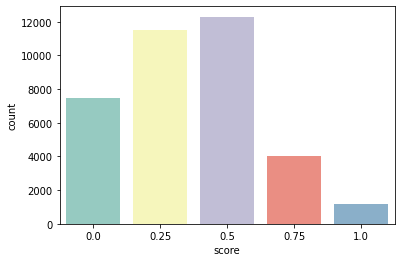

In [ ]:
#plot the count of each value in score
sns.countplot(x='score', data=df_train, palette='Set3')

        

Number of Rows having a score between 0 and 1: 35319
Number of Rows having a score of 0: 7471
Number of Rows having a score of 1: 1154


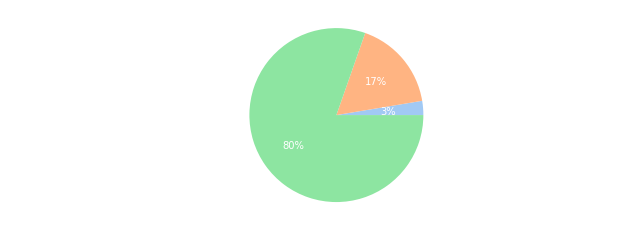

In [ ]:
#plot the
number_one=len(df_train[df_train["score"]==1])
number_0=len(df_train[df_train["score"]==0])
number_between=len(df_train[df_train["score"]!=0]) and len(df_train[df_train["score"]!=1])
#define data
data = [number_one,number_0,number_between]
labels = ['Number of Rows having a score of 1 ', 'Number of Rows having a score of 0 ', 'Number of Rows having a score between 0 and 1  ']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]
print(f"Number of Rows having a score between 0 and 1: {number_between}")
print(f"Number of Rows having a score of 0: {number_0}")
print(f"Number of Rows having a score of 1: {number_one}")

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%',textprops={'color':"w"})
plt.show()

### anchor

In [ ]:
print(f"number of row in anchor :{df_train.anchor.shape}")
print(f"unique values in anchor:{df_train.anchor.nunique()}")


number of row in anchor :(36473,)
unique values in anchor:733


In [ ]:
df_train

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


Most commun phrases (anchor) 

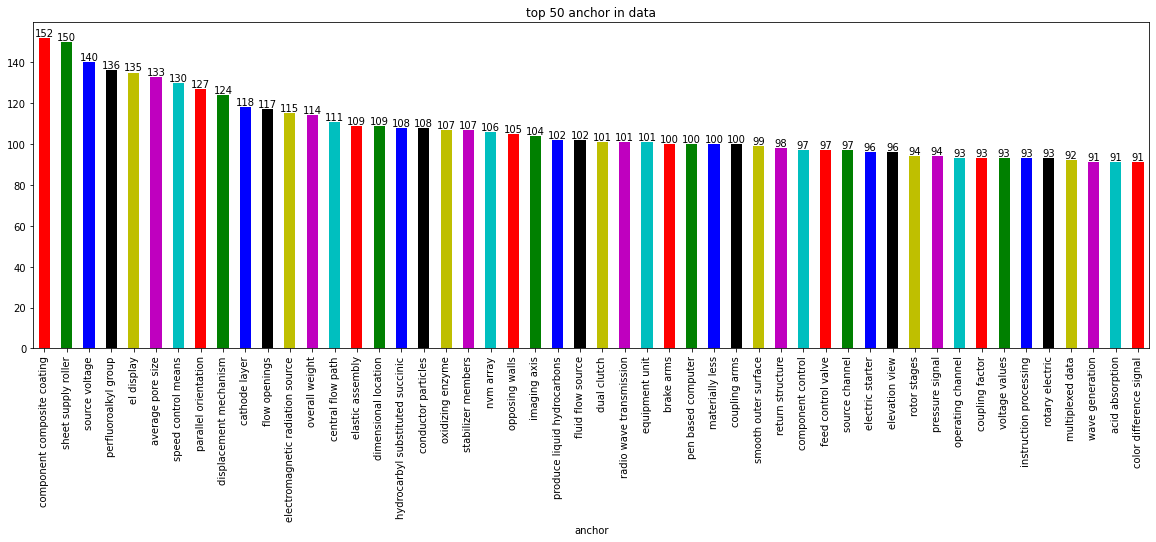

In [ ]:
plt.figure(figsize=(20, 6))

ax=df_train.groupby('anchor')['id'].count().sort_values(ascending=False).head(50).plot(kind='bar',color = list('rgbkymc'))
for container in ax.containers:
    ax.bar_label(container)
plt.title("top 50 anchor in data")
#plt.xticks(rotation=60)

plt.show()


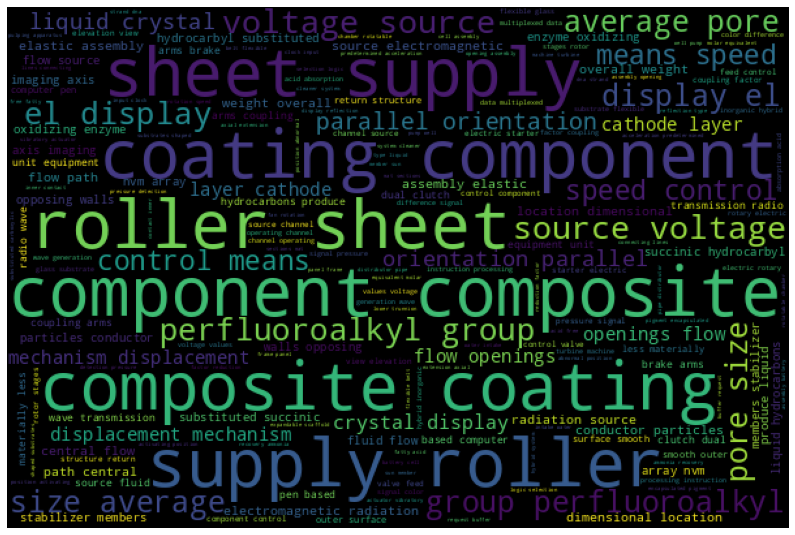

In [ ]:
wordcloud= WordCloud(stopwords=STOPWORDS, max_font_size=80, max_words=5000,
                      width = 600, height = 400,
                      background_color='black').generate(' '.join(txt for txt in df_train["anchor"]))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

### target

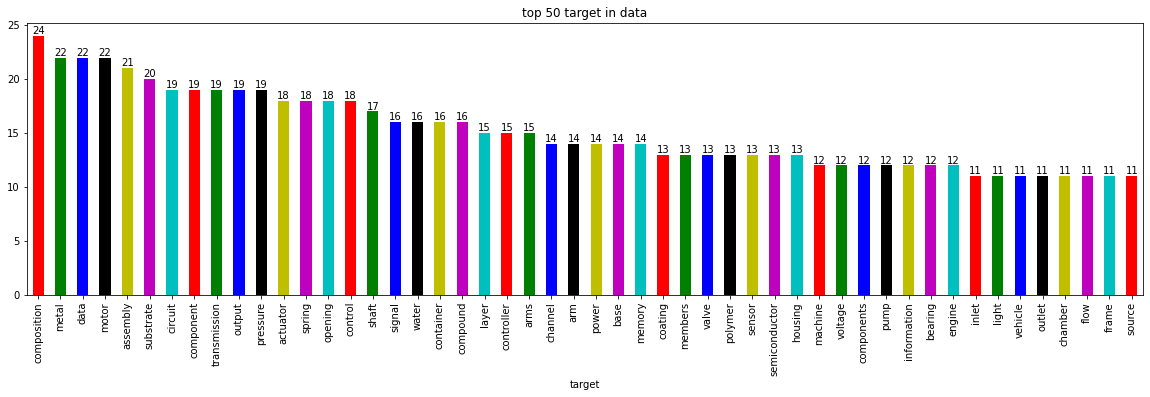

In [ ]:
plt.figure(figsize=(20,5))
tar=df_train.groupby('target')['id'].count().sort_values(ascending= False).head(50).plot(kind='bar',color=list('rgbkymc'))

for countainr in tar.containers:
    tar.bar_label(countainr)
    
plt.title("top 50 target in data")

plt.show()
    
    

"""""
wordcloud = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=80, max_words=5000,
                      width = 600, height = 400,
                      background_color='black').generate(' '.join(txt for txt in df_train["target"]))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);


### contex

In [ ]:
df_train['context'].nunique()

106

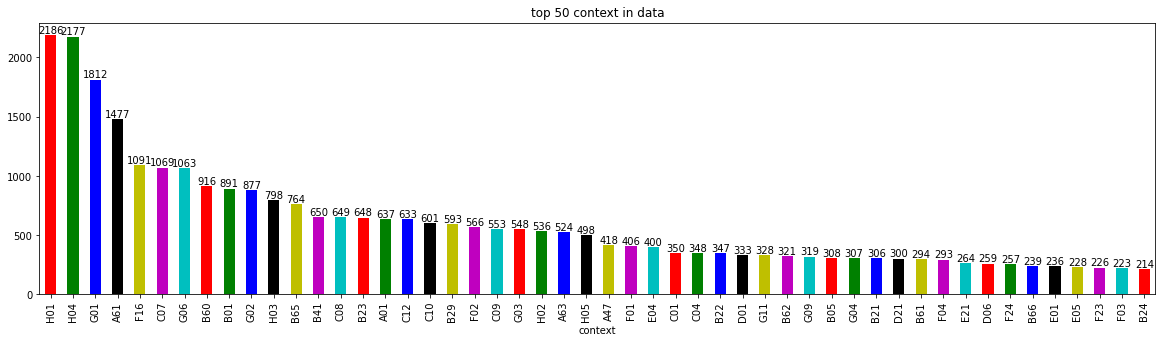

In [ ]:
plt.figure(figsize=(20,5))
con=df_train.groupby('context')['id'].count().sort_values(ascending=False).head(50).plot(kind='bar',color=list('rgbkymc'))

for container in con.containers:
    con.bar_label(container)
    
plt.title("top 50 context in data")
plt.show()

like we see in this graph the first letter in the context ih assigned to the "section" this is followed with two number who represent the " class symbol"

In [ ]:
df_train["section"]=df_train['context'].astype(str).str[0]
df_train['class']=df_train['context'].astype(str).str[1:]
df_train

,id,anchor,target,context,score,section,class
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,A,47
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,A,47
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,A,47
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,A,47
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,A,47
...,...,...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00,B,44
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50,B,44
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50,B,44
36471,756ec035e694722b,wood article,wooden material,B44,0.75,B,44


### score

<AxesSubplot:title={'center':'Score'}>

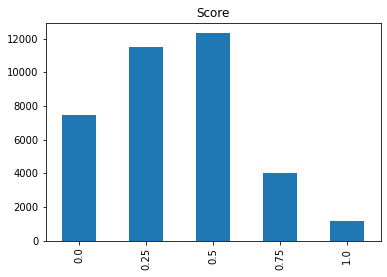

In [ ]:
df_train.score.value_counts().sort_index().plot(kind='bar',title="Score")

# Model

In [ ]:
cpc = pd.read_csv('../input/cpc-codes/titles.csv')
cpc.head()

,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...,A,1.0,NaN,NaN,NaN
2,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...,A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 ...,A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3...,A,1.0,B,1.0,2.0


In [ ]:
cpc = cpc.rename(columns = {"code" : "context"})
train_df = pd.merge(df_train, cpc[["context","title"]], on ="context", how = "left")
train_df.head()

,id,anchor,target,context,score,section,class,title
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,A,47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,A,47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,A,47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,A,47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,A,47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...


In [ ]:
def clean(x):
    t = x.lower()
    t = t.replace("[",'')
    t = t.replace(";",'')
    t = t.replace(",",'')
    t = t.replace("]",'')
    t = t.replace(":",'')
    return t

train_df['title'] = train_df['title'].apply(lambda x: clean(x))
train_df.head()

,id,anchor,target,context,score,section,class,title
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,A,47,furniture domestic articles or appliances coff...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,A,47,furniture domestic articles or appliances coff...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,A,47,furniture domestic articles or appliances coff...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,A,47,furniture domestic articles or appliances coff...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,A,47,furniture domestic articles or appliances coff...


In [ ]:
train_df['sen1'] = train_df['anchor'].astype('str')+' '+train_df['title'].astype('str')
train_df = train_df.drop(['anchor','context','title'],axis=1)
# train_df['all_sen'] = train_df['sen1']+' [SEP '+train_df['target']
train_df.head()

,id,target,score,section,class,sen1
0,37d61fd2272659b1,abatement of pollution,0.50,A,47,abatement furniture domestic articles or appli...
1,7b9652b17b68b7a4,act of abating,0.75,A,47,abatement furniture domestic articles or appli...
2,36d72442aefd8232,active catalyst,0.25,A,47,abatement furniture domestic articles or appli...
3,5296b0c19e1ce60e,eliminating process,0.50,A,47,abatement furniture domestic articles or appli...
4,54c1e3b9184cb5b6,forest region,0.00,A,47,abatement furniture domestic articles or appli...


In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(train_df[['target','sen1']],train_df['score'],random_state=1234,test_size=0.3)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(25531, 2) (10942, 2)
(25531,) (10942,)


In [ ]:
x_train

,target,sen1
10567,electroluminescent display,el display optics
23594,extend in parallel orientation,parallel orientation photography cinematograph...
33886,trommel separator,trommel screen crushing pulverising or disinte...
16986,messenger rna,insert nucleic acid biochemistry beer spirits ...
22199,opposing muscle,opposing walls vehicles in general
...,...,...
32399,finger ring,sun member engineering elements and units gene...
17048,total insertion loss,insertion losses basic electronic circuitry
23924,perfluorocarbon alkyl radical,perfluoroalkyl group machine tools metal-worki...
34086,turbine engine assembly,turbine machine machines or engines in general...


In [ ]:
x_test.head()


,target,sen1
5145,vector art,channel vectors electric communication technique
12992,construction device,fire ring building
23331,page file suitable,page file electric communication technique
26548,processor,pulping apparatus paper-making production of c...
34133,header,type parameter computing calculating counting


In [ ]:
y_test.head()


5145     0.00
12992    0.25
23331    0.75
26548    0.25
34133    0.25
Name: score, dtype: float64

In [ ]:
import torch
import torch.nn as nn
import transformers
from torch.nn.utils.clip_grad import clip_grad_norm


torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [ ]:
class my_model(nn.Module):
    def __init__(self,bert_path):
        super(my_model,self).__init__()
        self.bert_path = bert_path
        self.bert = transformers.AutoModel.from_pretrained(self.bert_path)
        self.fc_layer = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1024,1),
            nn.Sigmoid()
        )
    def forward(self,ids,mask,token_type_ids):
        out = self.bert(input_ids=ids,attention_mask=mask,token_type_ids=token_type_ids,return_dict=True)
        pooler_output = out.get('pooler_output')
        bo = self.fc_layer(pooler_output)
        return bo

In [ ]:
class my_dataset_train:
    def __init__(self,text1,text2,label,tokenizer,max_len):
        self.text1=text1
        self.text2=text2
        self.label=label
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text1)
    
    def __getitem__(self,idx):
        text_1 = str(self.text1[idx])
        text_2 = str(self.text2[idx])
        label = self.label[idx]
        
        inputs = self.tokenizer(
            text_1,
            text_2,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_attention_mask=True
        )
        
        ids = inputs['input_ids']
        token_type_ids = inputs["token_type_ids"]
        mask = inputs['attention_mask']
        
        padding_len = self.max_len - len(ids)
        ids = ids + ([0]*padding_len)
        token_type_ids = token_type_ids + ([0]*padding_len)
        mask = mask + ([0]*padding_len)
        
        return {
            "ids": torch.tensor(ids,dtype=torch.long),
            "mask": torch.tensor(mask,dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids,dtype=torch.long),
            "targets": torch.tensor(label,dtype=torch.float),
        }

In [ ]:
max_len=128
train_batch_size = 16
epochs=4
bert_path = '../input/bert-for-patents/bert-for-patents'

tokenizer = transformers.AutoTokenizer.from_pretrained(bert_path)

# Training dataset prep

train_text1 = list(x_train['target'].values)
train_text2 = list(x_train['sen1'].values)
train_label = list(y_train.values)

train_dataset = my_dataset_train(
    text1 = train_text1,
    text2 = train_text2,
    label = train_label,
    tokenizer=tokenizer ,
    max_len=max_len
)

train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True)

# validation dataset prep
val_text1 = list(x_test['target'].values)
val_text2 = list(x_test['sen1'].values)
val_label = list(y_test.values)

valid_dataset = my_dataset_train(
    text1 = val_text1,
    text2 = val_text2,
    label = val_label,
    tokenizer=tokenizer,
    max_len=max_len
    )

valid_data_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=train_batch_size,shuffle=True)

In [ ]:
def train(model, optimizer, scheduler, loss_function, epochs,train_dataloader, device, clip_value=2):
    model.train()
    for epoch in range(epochs):
#         print(epoch)
#         print("-----")
        best_loss = []
        for step, batch in enumerate(train_dataloader): 
            batch_inputs, batch_masks, batch_labels = batch['ids'].to(device), batch['mask'].to(device), batch['targets'].to(device)
            batch_token_type_ids = batch['token_type_ids'].to(device)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks, batch_token_type_ids)
            loss = loss_function(outputs.squeeze(),batch_labels.squeeze())
            best_loss.append(loss)
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
#             print(f"step > {step},loss > {loss}")
        loss2 = sum(best_loss)/len(best_loss)
        print(f'Epoch : {epoch} ,Train loss : {loss2}')
                
    return model

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2
def evaluate(model,loss_function,test_dataloader,device):
    model.eval()
    test_loss, test_r2 = [], []
    for step,batch in enumerate(test_dataloader):
        batch_inputs, batch_masks, batch_labels = batch['ids'].to(device), batch['mask'].to(device), batch['targets'].to(device)
        batch_token_type_ids = batch['token_type_ids'].to(device)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks, batch_token_type_ids)
        loss = loss_function(outputs, batch_labels)
        test_loss.append(loss.item())
        r2 = r2_score(outputs, batch_labels)
        test_r2.append(r2.item())
    return test_loss, test_r2

In [ ]:
import os


In [ ]:
num_train_steps = len(train_data_loader) * epochs

model = my_model(bert_path).to(device)

optimizer = transformers.AdamW(model.parameters(),lr=3e-5,eps=1e-8)

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

loss_function = nn.MSELoss()


model = train(model, optimizer, scheduler, loss_function, epochs,train_data_loader, device)


loss1,r2_ = evaluate(model,loss_function,valid_data_loader,device)

loss = sum(loss1)/len(loss1)
r2 = sum(r2_)/len(r2_)
print(f"eval mean result : loss {loss}, r2 {r2}")

Some weights of the model checkpoint at ../input/bert-for-patents/bert-for-patents were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This imple

Epoch : 0 ,Train loss : 0.03640398383140564
Epoch : 1 ,Train loss : 0.02156822197139263
Epoch : 2 ,Train loss : 0.013673963956534863
Epoch : 3 ,Train loss : 0.008932859636843204


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


eval mean result : loss 0.11987905064870043, r2 -29.579103073878596


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
torch.save(model.state_dict(),f'./my_bert')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

9929

In [ ]:
test_df = pd.read_csv('../input/us-patent-phrase-to-phrase-matching/test.csv')
test_df.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [ ]:
cpc = pd.read_csv('../input/cpc-codes/titles.csv')
cpc = cpc.rename(columns = {"code" : "context"})
test_df = pd.merge(test_df, cpc[["context","title"]], on ="context", how = "left")

def clean(x):
    t = x.lower()
    t = t.replace("[",'')
    t = t.replace(";",'')
    t = t.replace(",",'')
    t = t.replace("]",'')
    t = t.replace(":",'')
    return t
test_df['title'] = test_df['title'].apply(lambda x: clean(x))
test_df.head()

,id,anchor,target,context,title
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,optics
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,combustion apparatus combustion processes
2,36baf228038e314b,lower trunnion,lower locating,B60,vehicles in general
3,1f37ead645e7f0c8,cap component,upper portion,D06,treatment of textiles or the like laundering f...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,electric communication technique


In [ ]:
test_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       36 non-null     object
 1   anchor   36 non-null     object
 2   target   36 non-null     object
 3   context  36 non-null     object
 4   title    36 non-null     object
dtypes: object(5)
memory usage: 1.7+ KB


In [ ]:
test_df['sen1'] = test_df['anchor'].astype('str')+' '+test_df['title'].astype('str')
test_df = test_df.drop(['anchor','context','title'],axis=1)
test_df.head()

,id,target,sen1
0,4112d61851461f60,inorganic photoconductor drum,opc drum optics
1,09e418c93a776564,altering gas flow,adjust gas flow combustion apparatus combustio...
2,36baf228038e314b,lower locating,lower trunnion vehicles in general
3,1f37ead645e7f0c8,upper portion,cap component treatment of textiles or the lik...
4,71a5b6ad068d531f,artificial neural network,neural stimulation electric communication tech...


In [ ]:
class my_dataset_test:
    def __init__(self,text1,text2,idf,tokenizer,max_len):
        self.text1=text1
        self.text2=text2
        self.idf = idf
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text1)
    
    def __getitem__(self,idx):
        text_1 = str(self.text1[idx])
        text_2 = str(self.text2[idx])
        idf = self.idf[idx]
        
        inputs = self.tokenizer(
            text_1,
            text_2,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_attention_mask=True
        )
        
        ids = inputs['input_ids']
        token_type_ids = inputs["token_type_ids"]
        mask = inputs['attention_mask']
        padding_len = self.max_len - len(ids)
        ids = ids + ([0]*padding_len)
        token_type_ids = token_type_ids + ([0]*padding_len)
        mask = mask + ([0]*padding_len)
        
        return {
            "ids": torch.tensor(ids,dtype=torch.long),
            "mask": torch.tensor(mask,dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids,dtype=torch.long),
            "idf": idf
        }
        

In [ ]:
test_text1 = list(test_df['target'].values)
test_text2 = list(test_df['sen1'].values)

test_dataset = my_dataset_test(
    text1 = test_text1,
    text2 = test_text2,
    idf=list(test_df['id'].values),
    tokenizer=tokenizer,
    max_len=max_len
)

test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True)

In [ ]:
def predict(model,test_dataloader,device):
    model.eval()
    result = []
    for step,batch in enumerate(test_dataloader):
        batch_inputs, batch_masks = batch['ids'].to(device), batch['mask'].to(device)
        batch_token_type_ids = batch['token_type_ids'].to(device)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks, batch_token_type_ids)
        out = [i[0] for i in outputs.cpu().detach().numpy()]
        batch_idf = batch['idf']
        temp = [[i,j] for i,j in zip(batch_idf,out)]
        result.extend(temp)
    return result

In [ ]:
model = my_model(bert_path).to(device)
model.load_state_dict(torch.load('my_bert'))

final_res = predict(model,test_data_loader,device)

Some weights of the model checkpoint at ../input/bert-for-patents/bert-for-patents were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
final_res


[['25c555ca3d5a2092', 0.7508547],
 ['7e3aff857f056bf9', 0.005223202],
 ['b9ea2b06a878df6f', 0.526688],
 ['c057aecbba832387', 0.005052727],
 ['26c3c6dc6174b589', 0.005170485],
 ['9f2279ce667b21dc', 0.745841],
 ['8247ff562ca185cc', 0.1665483],
 ['12ca31f018a2e2b9', 0.27054855],
 ['16ae4b99d3601e60', 0.2603924],
 ['733979d75f59770d', 0.38965246],
 ['1f37ead645e7f0c8', 0.21585627],
 ['fd83613b7843f5e1', 0.14250687],
 ['de51114bc0faec3e', 0.0051852935],
 ['c404f8b378cbb008', 0.5434765],
 ['2a619016908bfa45', 0.52791774],
 ['6546846df17f9800', 0.45222327],
 ['ae0262c02566d2ce', 0.98967135],
 ['7aa5908a77a7ec24', 0.26447108],
 ['474c874d0c07bd21', 0.5160927],
 ['78243984c02a72e4', 0.005693093],
 ['3ff0e7a35015be69', 0.23685087],
 ['b8ae62ea5e1d8bdb', 0.0066091437],
 ['5203a36c501f1b7c', 0.8543993],
 ['25522ee5411e63e9', 0.25409737],
 ['b9fdc772bb8fd61c', 0.76203203],
 ['b892011ab2e2cabc', 0.73953104],
 ['442c114ed5c4e3c9', 0.4348906],
 ['71a5b6ad068d531f', 0.00547922],
 ['4112d61851461f60', 0

In [ ]:
submit_csv = pd.DataFrame(final_res,columns=['id','score'])
submit_csv.head()

,id,score
0,25c555ca3d5a2092,0.750855
1,7e3aff857f056bf9,0.005223
2,b9ea2b06a878df6f,0.526688
3,c057aecbba832387,0.005053
4,26c3c6dc6174b589,0.005170


In [ ]:
submit_csv.to_csv('submission.csv',index=False)
